In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import utils
import exact_diagonalization as ed
import scipy
import h5py
from machines import mps_trotter

data_dir = "D:/DATA/ClockV2/final_dense"

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


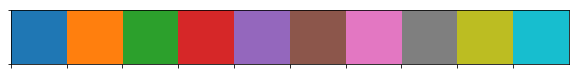

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 20

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

C:\Users\Stavros\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


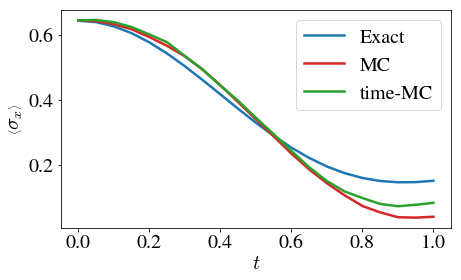

In [9]:
n_sites = 6
time_steps = 20
h_init = 1.0
h_ev = 0.5
t = np.linspace(0.0, 1.0, time_steps + 1)


fstate_sampling = np.load("{}/sampling20000_mpsD3_N{}M{}.npy".format(data_dir, n_sites, time_steps))
fstate_spacesampling = np.load("{}/spacesampling1000_mpsD3_N{}M{}.npy".format(data_dir, n_sites, time_steps))
exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev, dtype=fstate_sampling.dtype)

pauli = utils.Pauli(dtype=exact_state.dtype)
sampling_X = utils.ev_local(fstate_sampling, pauli.X)
spacesampling_X = utils.ev_local(fstate_spacesampling, pauli.X)

plt.figure(figsize=(7, 4))
plt.plot(t, exact_obs["X"], color=cp[0], linewidth=2.5, label="Exact")
plt.plot(t, spacesampling_X, color=cp[3], linewidth=2.5, label="MC")
plt.plot(t, sampling_X, color=cp[2], linewidth=2.5, label="time-MC")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend()
plt.show()

Normalize states before calculating observables

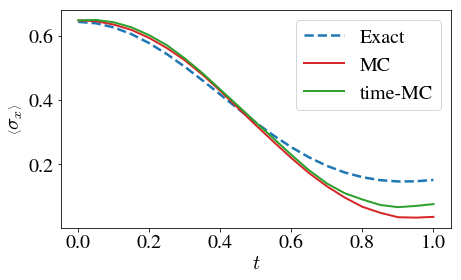

In [13]:
fstate_sampling *= 1.0 / np.sqrt((np.abs(fstate_sampling)**2).sum(axis=1))[:, np.newaxis]
fstate_spacesampling *= 1.0 / np.sqrt((np.abs(fstate_spacesampling)**2).sum(axis=1))[:, np.newaxis]

sampling_X = utils.ev_local(fstate_sampling, pauli.X)
spacesampling_X = utils.ev_local(fstate_spacesampling, pauli.X)

plt.figure(figsize=(7, 4))
plt.plot(t, exact_obs["X"], "--", color=cp[0], linewidth=2.5, label="Exact")
plt.plot(t, spacesampling_X, color=cp[3], linewidth=2.0, label="MC")
plt.plot(t, sampling_X, color=cp[2], linewidth=2.0, label="time-MC")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend()
plt.show()

In [3]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

ham0 = utils.tfim_hamiltonian(n_sites, h=0.0)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
hamf = ham - ham0

data_dir = "C:/DATA/ClockV2/histories"

In [6]:
time_steps_list = [20, 30, 40, 50, 60, 80, 100]

overlaps = {"trotter": [], "system": [], "optimized": []}
for time_steps in time_steps_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    u_list = [scipy.linalg.expm(-1j * dt * ham0), scipy.linalg.expm(-1j * dt * hamf)]
    trotter_state = utils.tfim_trotterized_evolution(u_list, exact_state[0], time_steps)

    clock = ed.construct_sparse_clock(ham0 + hamf, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], scipy.sparse.linalg.gmres)
    
    optimized = h5py.File("{}/N=6/allstates_fullwv_N6M{}.h5py".format(data_dir, time_steps), "r")
    
    overlaps["optimized"].append(optimized["overlaps"][-1])
    overlaps["trotter"].append(utils.averaged_overlap(exact_state, trotter_state))
    overlaps["system"].append(utils.averaged_overlap(exact_state, system_state))
    
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0


In [33]:
labels = {"optimized": "Clock opt.", "trotter": "Trotter", "system": "Clock system"}

plt.figure(figsize=(7, 4))
plt.suptitle("Full Wavefunction, $N=6$, $t_f=1.0$")
markers = ["o", "s", "^"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(time_steps_list, 1 - overlaps[k], color=cp[i], marker=markers[i], markersize=8, linewidth=2.5, label=labels[k])
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
#plt.show()
plt.savefig("fullwv_trotter_clock.pdf", bbox_inches='tight')

Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0


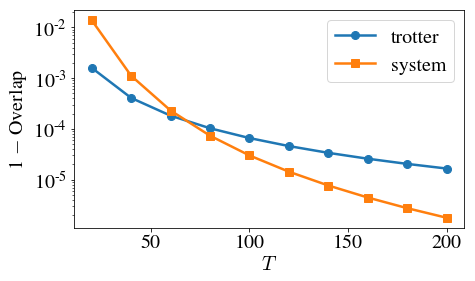

In [47]:
time_steps_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

overlaps = {"trotter": [], "system": []}
for time_steps in time_steps_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    u_list = [scipy.linalg.expm(-1j * dt * ham0), scipy.linalg.expm(-1j * dt * hamf)]
    trotter_state = utils.tfim_trotterized_evolution(u_list, exact_state[0], time_steps)

    clock = ed.construct_sparse_clock(ham0 + hamf, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], scipy.sparse.linalg.gmres)
    
    overlaps["trotter"].append(utils.averaged_overlap(exact_state, trotter_state))
    overlaps["system"].append(utils.averaged_overlap(exact_state, system_state))
    
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])


plt.figure(figsize=(7, 4))
markers = ["o", "s", "^"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(time_steps_list, 1 - overlaps[k], color=cp[i], marker=markers[i], markersize=8, linewidth=2.5, label=k)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0


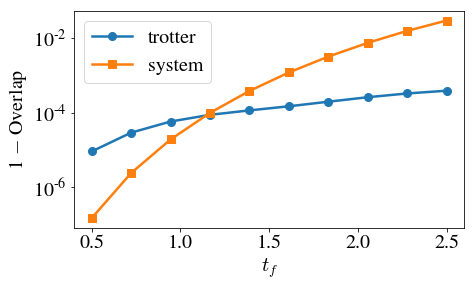

In [49]:
time_steps = 100
tf_list = np.linspace(0.5, 2.5, 10)

overlaps = {"trotter": [], "system": []}
for tf in tf_list:
    t = np.linspace(0.0, tf, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    u_list = [scipy.linalg.expm(-1j * dt * ham0), scipy.linalg.expm(-1j * dt * hamf)]
    trotter_state = utils.tfim_trotterized_evolution(u_list, exact_state[0], time_steps)

    clock = ed.construct_sparse_clock(ham0 + hamf, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], scipy.sparse.linalg.gmres)
    
    overlaps["trotter"].append(utils.averaged_overlap(exact_state, trotter_state))
    overlaps["system"].append(utils.averaged_overlap(exact_state, system_state))
    
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])


plt.figure(figsize=(7, 4))
markers = ["o", "s", "^"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(tf_list, 1 - overlaps[k], color=cp[i], marker=markers[i], markersize=8, linewidth=2.5, label=k)
plt.xlabel("$t_f$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Convergence status: 0


C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


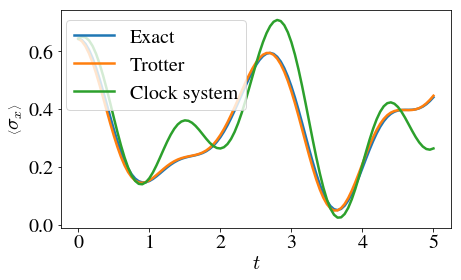

In [19]:
time_steps = 100
t = np.linspace(0.0, 5.0, time_steps + 1)
dt = t[1] - t[0]

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
pauli = utils.Pauli(dtype=exact_state.dtype)

u_list = [scipy.linalg.expm(-1j * dt * ham0), scipy.linalg.expm(-1j * dt * hamf)]
trotter_state = utils.tfim_trotterized_evolution(u_list, exact_state[0], time_steps)

clock = ed.construct_sparse_clock(ham0 + hamf, dt, time_steps)
system_state = ed.solve_evolution_system(clock, exact_state[0], scipy.sparse.linalg.gmres)
system_state *= 1.0 / np.sqrt((np.abs(system_state)**2).sum(axis=1))[:, np.newaxis]
    
trotter_X = utils.ev_local(trotter_state, pauli.X)
system_X = utils.ev_local(system_state, pauli.X)

In [34]:
plt.figure(figsize=(7, 4))
markers = ["o", "s", "^"]
plt.suptitle("Full Wavefunction, $N=6$, $T=100$")
plt.plot(t, exact_obs["X"], color=cp[0], linewidth=2.5, label="Exact")
plt.plot(t, trotter_X, color=cp[1], linewidth=2.5, label="Trotter")
plt.plot(t, system_X, color=cp[2], linewidth=2.5, label="Clock system")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.08))
plt.savefig("fullwv_trotter_clock_obs.pdf", bbox_inches='tight')
#plt.show()

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
